In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [2]:
!jupyter --version

jupyter core     : 4.7.1
jupyter-notebook : 6.4.3
qtconsole        : 5.1.0
ipython          : 7.26.0
ipykernel        : 6.2.0
jupyter client   : 6.1.12
jupyter lab      : not installed
nbconvert        : 6.1.0
ipywidgets       : 7.6.3
nbformat         : 5.1.3
traitlets        : 5.0.5


In [3]:
import pkg_resources
import sys
print("Pandas: " + pkg_resources.get_distribution("pandas").version)
print("NumPy: " + pkg_resources.get_distribution("numpy").version)
print("MatPlotLib: " + pkg_resources.get_distribution("matplotlib").version)
print("Seaborn: " + pkg_resources.get_distribution("seaborn").version)
print("Scikit-Learn: " + pkg_resources.get_distribution("scikit-learn").version)
print("StatModels: " + pkg_resources.get_distribution("statsmodels").version)
print("Python: " + sys.version)

Pandas: 1.3.2
NumPy: 1.20.3
MatPlotLib: 3.4.2
Seaborn: 0.11.2
Scikit-Learn: 0.24.2
StatModels: 0.12.2
Python: 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]


In [4]:
data = pd.read_csv('medical_clean.csv')

In [5]:
pd.set_option('display.max_columns', None)
print(data.describe())

         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  50159.323900     38.751099    -91.243080    9965.253800   
std     2886.89568  27469.588208      5.403085     15.205998   14824.758614   
min        1.00000    610.000000     17.967190   -174.209700       0.000000   
25%     2500.75000  27592.000000     35.255120    -97.352982     694.750000   
50%     5000.50000  50207.000000     39.419355    -88.397230    2769.000000   
75%     7500.25000  72411.750000     42.044175    -80.438050   13945.000000   
max    10000.00000  99929.000000     70.560990    -65.290170  122814.000000   

           Children           Age         Income   VitD_levels    Doc_visits  \
count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
mean       2.097200     53.511700   40490.495160     17.964262      5.012200   
std        2.163659     20.638538   28521.153293

In [6]:
#Divide the data depending on the variable type
data_num = data.iloc[:, np.r_[8:11, 14:17, 20:24, 39:50]].copy() #Numeric variables
data_enc = data.iloc[:, np.r_[17:19, 38]].copy() #Non-binary Categorical Variables
data_yn = data.iloc[:, np.r_[19, 24, 26, 27, 29:38]].copy() #Binary Categorical Variables
data_ord = data.iloc[:, [11, 25, 28]].copy() #Ordinal Categorical Variables

In [7]:
def meddata_preprocessing(data_num, data_enc, data_yn, data_ord): #This is saved as a function for reusability in later tasks
    for i in range(len(data_num.columns)):
        #Compute the mean and standard deviation of each column
        mean, std = np.mean(data_num.iloc[:,i]), np.std(data_num.iloc[:,i])
        #Set the upper and lower bounds at three standard deviations from the mean
        upper, lower = mean + 3 * std, mean - 3 * std
        #Record the index for each row that contains a value outside the previously set boundaries
        drop = [inx for inx, x in enumerate(data_num.iloc[:, i]) if x < lower or x > upper]
        #Compare the list of indices to be dropped with those within the dataframe and drop those that still remain
        #within the data frame while ignoring those that were already dropped
        for d in drop:
            if d in data_num.index:
                data_num = data_num.drop(d)
    #One-hot encode categorical variables
    data_enc = pd.get_dummies(data_enc, prefix=data_enc.columns, drop_first=True)
        
    for col in range(len(data_yn.columns)):
        #Replace values of "Yes" with 1 and values of "No" with 0
        for inx, val in enumerate(data_yn.iloc[:, col]):
            if val == 'Yes':
                data_yn.iloc[inx, col] = 1
            else:
                data_yn.iloc[inx, col] = 0
    #Determine levels of ordinal variables
    scale_mapper = {
        "Area" : {
            "Rural" : 0,
            "Suburban" : 0.5,
            "Urban" : 1
        },
        "Initial_admin" : {
            "Emergency Admission" : 1,
            "Observation Admission" : 0.5,
            "Elective Admission" : 0
        },
        "Complication_risk" : {
            "Low" : 0,
            "Medium" : 0.5,
            "High" : 1
        }
    }
    #Replace values with numerical equivalents specified above
    for col in data_ord.columns:
        data_ord[col] = data_ord[col].copy().replace(scale_mapper[col])
    
    mm = MinMaxScaler() #Instantiate the MinMaxScaler method
    data_num[data_num.columns] = mm.fit_transform(data_num) #Standardize the data
    
    #The use of an inner join preserves the dropping of rows performed on data_num
    #The data_yn dataframe is converted to a numeric datatype, int32, before joining
    data_clean = data_num.copy().join(data_enc, how='inner').join(data_yn.astype('int32'), how='inner').join(data_ord, how='inner')
    
    return data_clean #Returns a fully prepared data set

In [8]:
#Call the preperation function
data_clean = meddata_preprocessing(data_num, data_enc, data_yn, data_ord)
data_clean #Preview the data

Lat       Lng  Population  Children       Age    Income  \
0     0.328436  0.817705    0.024028       0.1  0.492958  0.417305   
1     0.209447  0.831688    0.092033       0.3  0.464789  0.225268   
2     0.640590  0.725053    0.139439       0.3  0.492958  0.068645   
3     0.652617  0.754243    0.017604       0.0  0.845070  0.191156   
4     0.438762  0.909636    0.043049       0.1  0.056338  0.005097   
...        ...       ...         ...       ...       ...       ...   
9995  0.399034  0.897040    0.038774       0.2  0.098592  0.221220   
9996  0.501139  0.928484    0.010186       0.4  0.971831  0.071605   
9997  0.396918  0.812332    0.004332       0.3  0.380282  0.317553   
9998  0.659615  0.674784    0.002207       0.3  0.352113  0.142680   
9999  0.537262  0.878698    0.338105       0.8  0.732394  0.301932   

      VitD_levels  Doc_visits  Full_meals_eaten  vitD_supp  Initial_days  \
0        0.562756       0.625          0.000000        0.0      0.135022   
1        0.550632       0.375          0.285714        0.2      0.199037   
2        0.497410       0.375          0.142857        0.0      0.053117   
3        0.408150       0.375          0.142857        0.0      0.010044   
4        0.460128       0.500          0.000000        0.4      0.003562   
...           ...         ...               ...        ...           ...   
9995     0.432505       0.375          0.285714        0.2      0.712308   
9996     0.504615       0.500          0.000000        0.0      0.953321   
9997     0.441440       0.375          0.285714        0.0      0.974256   
9998     0.609113       0.500          0.285714        0.2      0.878492   
9999     0.517371       0.500          0.000000        0.2      0.984067   

      TotalCharge  Additional_charges     Item1     Item2     Item3     Item4  \
0        0.244938            0.539851  0.285714  0.333333  0.142857  0.166667   
1        0.309519            0.527956  0.285714  0.500000  0.285714  0.500000   
2        0.066007            0.524027  0.142857  0.500000  0.428571  0.500000   
3        0.023588            0.359607  0.285714  0.666667  0.571429  0.333333   
4        0.021545            0.021531  0.142857  0.000000  0.285714  0.333333   
...           ...                 ...       ...       ...       ...       ...   
9995     0.677462            0.211438  0.285714  0.166667  0.142857  0.333333   
9996     0.800778            0.924967  0.285714  0.333333  0.428571  0.166667   
9997     0.874815            0.442979  0.285714  0.333333  0.285714  0.500000   
9998     0.787320            0.169676  0.571429  0.666667  0.285714  0.500000   
9999     0.820971            0.310400  0.428571  0.333333  0.285714  0.166667   

         Item5     Item6     Item7     Item8  Marital_Married  \
0     0.500000  0.333333  0.333333  0.500000                0   
1     0.500000  0.500000  0.333333  0.333333                1   
2     0.333333  0.500000  0.333333  0.333333                0   
3     0.500000  0.666667  0.666667  0.666667                1   
4     0.666667  0.333333  0.500000  0.333333                0   
...        ...       ...       ...       ...              ...   
9995  0.500000  0.333333  0.500000  0.166667                0   
9996  0.666667  0.333333  0.500000  0.500000                0   
9997  0.500000  0.166667  0.333333  0.166667                0   
9998  0.500000  0.333333  0.500000  0.333333                0   
9999  0.333333  0.833333  0.500000  0.333333                0   

      Marital_Never Married  Marital_Separated  Marital_Widowed  Gender_Male  \
0                         0                  0                0            1   
1                         0                  0                0            0   
2                         0                  0                1            0   
3                         0                  0                0            1   
4                         0                  0                1            0   
...                    

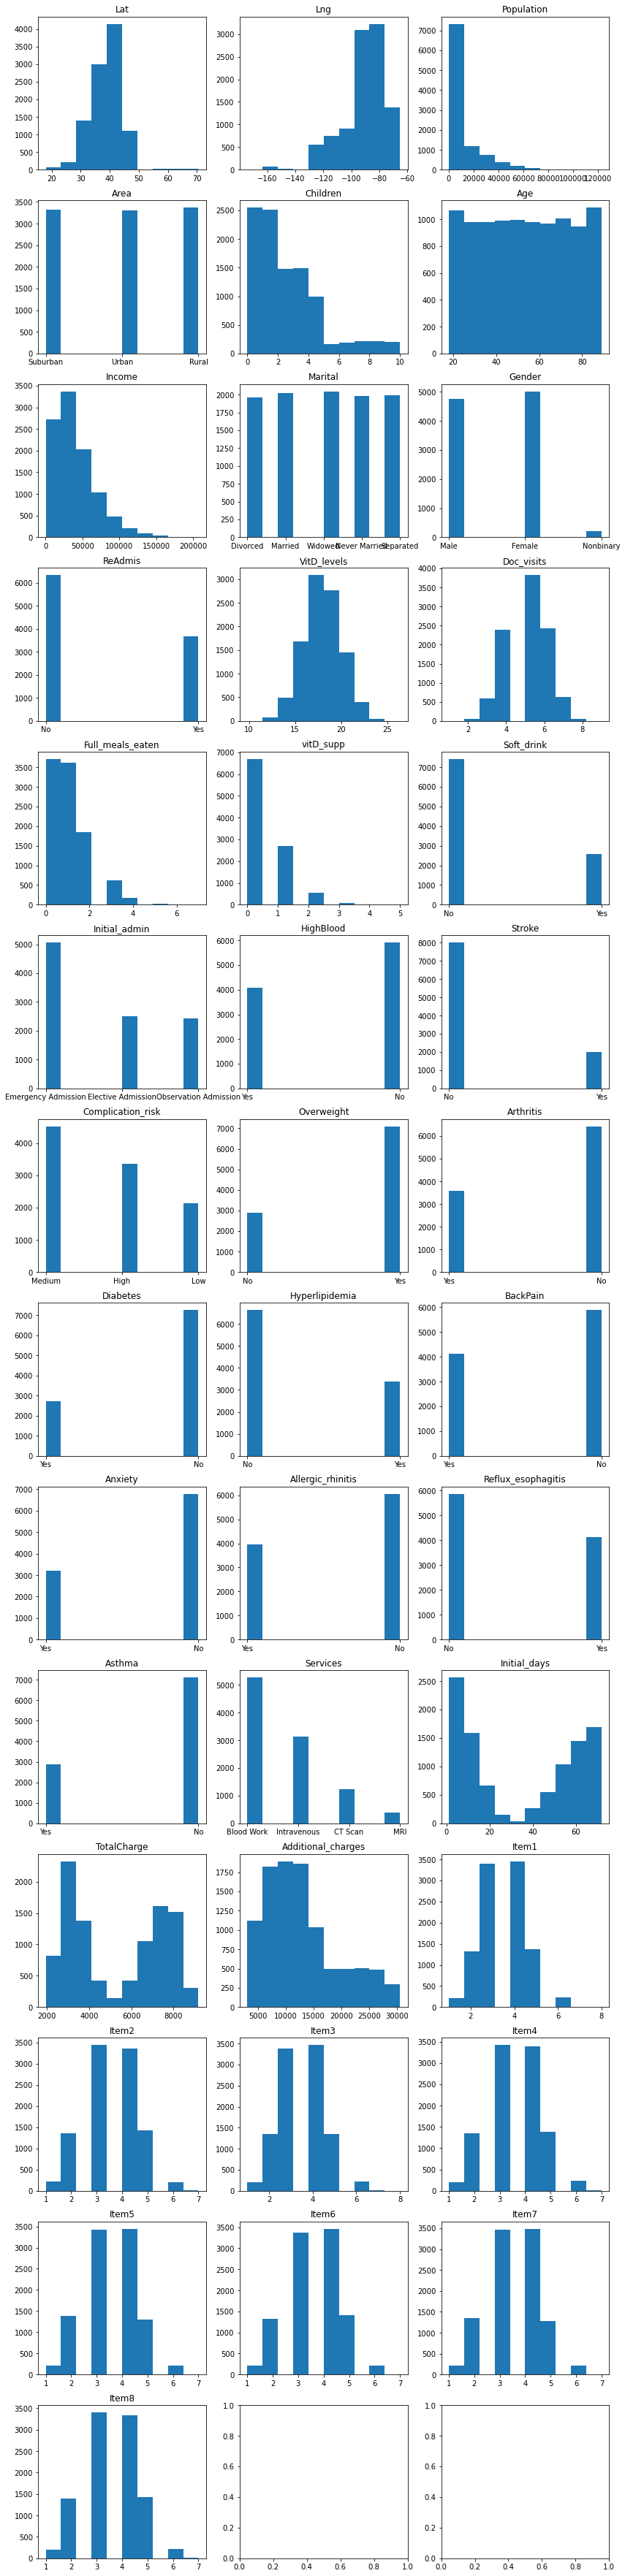

In [9]:
#Univariate distributions of all independent variables
fig, ax = plt.subplots(14, 3, sharey=False, figsize=(14, 64))

axi = 0
for i in np.r_[8:12, 14:50]:
    ax.flatten()[axi].hist(data.iloc[:, i])
    ax.flatten()[axi].set_title(data.columns[i])
    axi += 1

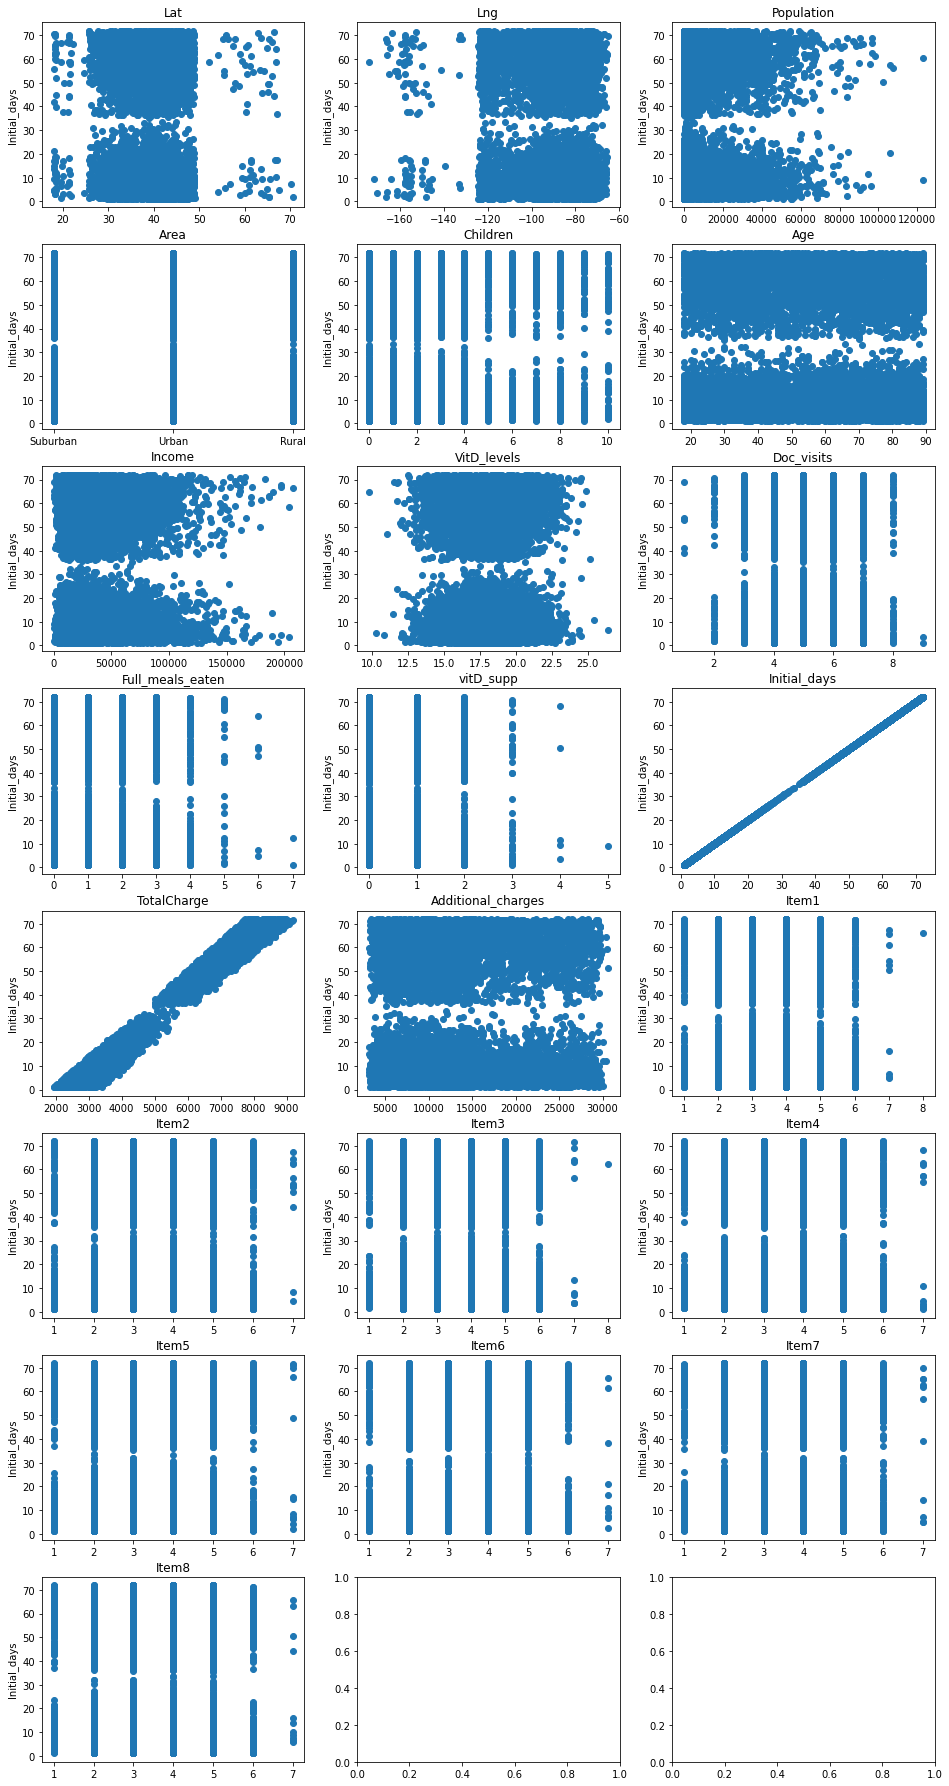

In [10]:
#Bivariate distributions for independent variable vs. the dependent variable
fig, ax = plt.subplots(8, 3, sharey=False, figsize=(16,32))

inx = 0
for i in np.r_[8:12, 14:17, 20:24, 39:50]:
    ax.flatten()[inx].scatter(data.iloc[:, i], data['Initial_days'], )
    ax.flatten()[inx].set_title(data.columns[i])
    ax.flatten()[inx].set_ylabel('Initial_days')
    inx += 1

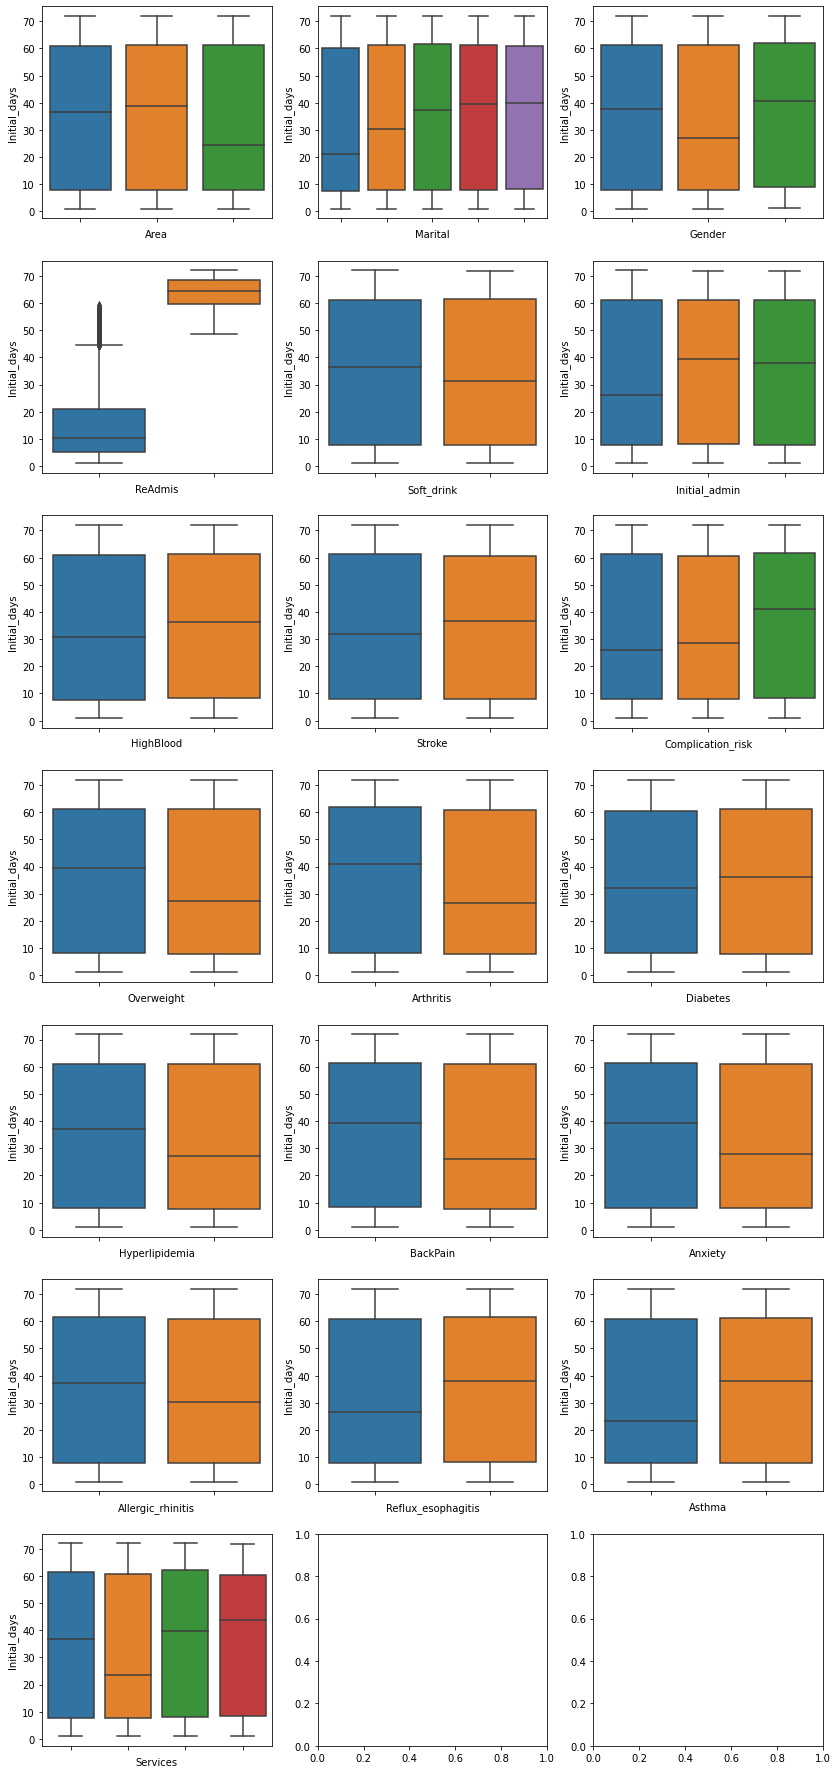

In [11]:
#Bivariate distributions continued
fig, ax = plt.subplots(7, 3, sharey=False, figsize=(14,32))

axi = 0
for i in np.r_[11, 17, 18, 19, 24, 25:39]:
    sns.boxplot(data=data, x=data.columns[i], y='Initial_days', ax=ax.flatten()[axi])
    ax.flatten()[axi].xaxis.set_ticklabels([])
    axi +=1

In [12]:
#Export prepared data to csv
data_clean.to_csv('med_data_prepared.csv')

In [13]:
#Divide prepared data into predictors (X) and target (y)
X = data_clean.drop('Initial_days', axis=1).copy()
y = data_clean['Initial_days'].copy()
#Add constant
X = add_constant(X)
#Instantiate and fit linear model
lin_reg = sm.OLS(y, X)
model_init = lin_reg.fit()
model_init.summary()

C:\Users\joshu\anaconda3\envs\jupyer-DS\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Initial_days   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.288e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:13:19   Log-Likelihood:                 20567.
No. Observations:                9123   AIC:                        -4.104e+04
Df Residuals:                    9077   BIC:                        -4.071e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0409      0.003     12.407      0.000       0.034       0.047
Lat                       0.0016      0.002      0.955      0.340      -0.002       0.005
Lng                      -0.0004      0.002     -0.205      0.838      -0.005       0.004
Population               -0.0004      0.002     -0.169      0.866      -0.005       0.004
Children                 -0.0014      0.001     -1.158      0.247      -0.004       0.001
Age                       0.0233      0.003      8.363      0.000       0.018       0.029
Income                    0.0018      0.002      0.909      0.363      -0.002       0.006
VitD_levels              -0.0002      0.002     -0.098      0.922      -0.005       0.004
Doc_visits            -2.736e-05      0.002     -0.013      0.989      -0.004       0.004
Full_meals_eaten          0.0010      0.002      0.538      0.591      -0.003       0.005
vitD_supp                -0.0046      0.002     -2.156      0.031      -0.009      -0.000
TotalCharge               1.2191      0.002    716.712      0.000       1.216       1.222
Additional_charges       -0.0412      0.005     -9.141      0.000      -0.050      -0.032
Item1                     0.0003      0.003      0.112      0.911      -0.005       0.006
Item2                  9.463e-05      0.002      0.044      0.965      -0.004       0.004
Item3                  8.306e-05      0.002      0.036      0.971      -0.004       0.005
Item4                    -0.0012      0.002     -0.689      0.491      -0.005       0.002
Item5                    -0.0009      0.002     -0.487      0.626      -0.005       0.003
Item6                     0.0005      0.002      0.276      0.783      -0.003       0.004
Item7                    -0.0042      0.002     -2.368      0.018      -0.008      -0.001
Item8                     0.0026      0.002      1.513      0.130      -0.001       0.006
Marital_Married          -0.0006      0.001     -0.677      0.498      -0.002       0.001
Marital_Never Married -5.507e-05      0.001     -0.065      0.948      -0.002       0.002
Marital_Separated         0.0002      0.001      0.236      0.814      -0.001       0.002
Marital_Widowed           0.0003      0.001      0.339      0.735      -0.001       0.002
Gender_Male               0.0002      0.001      0.297      0.767      -0.001       0.001
Gender_Nonbinary          0.0004      0.002      0.197      0.844      -0.003       0.004
Services_CT Scan         -0.0010      0.001     -1.195      0.232      -0.003       0.001
Services_Intravenous   5.528e-05      0.001      0.092      0.927      -0.001       0.001
Services_MRI           7.194e-06      0.001      0.005      0.996      -0.003       0.003
ReAdmis                   0.0120      0.001     11.355      0.000       0.010       0.014
Soft_drink             

<AxesSubplot:>

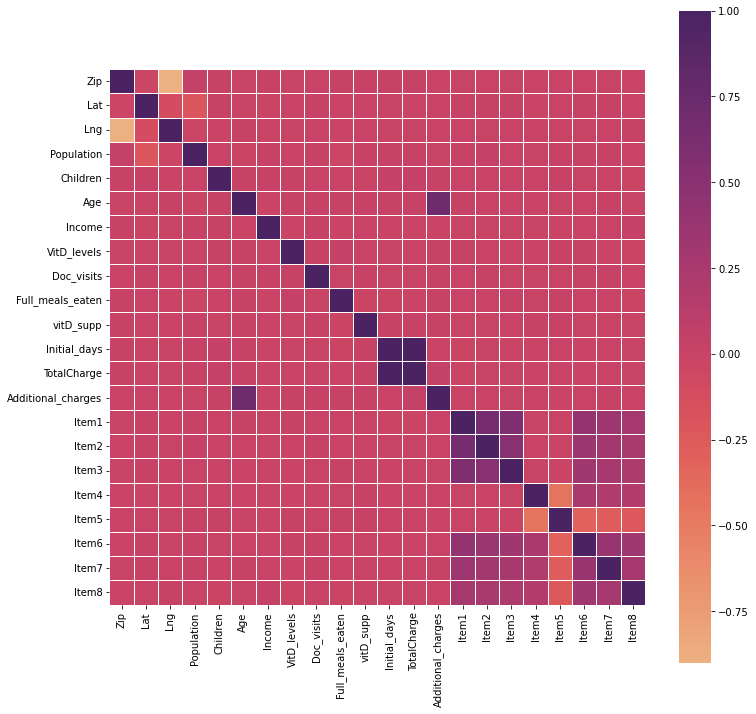

In [14]:
#Check for multicollinearity through heat-map of correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(data[data.columns[4:50]].corr(), linewidths=0.5, linecolor='white', cmap=sns.color_palette("flare", as_cmap=True), square=True)

In [15]:
#Remove highly correlated independent variables and confirm no strong correlations through second heat-map
X2 = X.drop(['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'Additional_charges'], axis=1).copy()

In [16]:
#Model reduction strategy is saved within a function for reusability
def reduce_model(X, y, sig_lvl):#Accepts predictor df, target series, and significance level
    lin_reg = sm.OLS(y, X)#Creates model
    model = lin_reg.fit()#Fits model
    p_val = model.pvalues.to_list()
    var = X.columns.to_list()

    while max(p_val) >= sig_lvl:#Breaks once all predictor variables are statistically significant
        for i in range(len(var)):
            if p_val[i] == max(p_val):
                X.drop(var[i], axis=1, inplace=True)#Drops variable with highest, non-significant p-value
        lin_reg = sm.OLS(y, X)#Recreates model
        model = lin_reg.fit()#Refits model
        p_val = model.pvalues.to_list()
        var = X.columns.to_list()
        
    return model, X#Returns a reduced model and the corresponding predictor variables

In [17]:
model_final, X_final = reduce_model(X2, y, 0.05)
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Initial_days   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.473e+05
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:13:20   Log-Likelihood:                 20516.
No. Observations:                9123   AIC:                        -4.100e+04
Df Residuals:                    9109   BIC:                        -4.090e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0441      0.001     46.743      0.000       0.042       0.046
vitD_supp             -0.0045      0.002     -2.103      0.036      -0.009      -0.000
TotalCharge            1.2192      0.002    715.444      0.000       1.216       1.223
ReAdmis                0.0118      0.001     11.187      0.000       0.010       0.014
HighBlood             -0.0182      0.001    -33.405      0.000      -0.019      -0.017
Arthritis             -0.0114      0.001    -20.328      0.000      -0.012      -0.010
Diabetes              -0.0127      0.001    -21.113      0.000      -0.014      -0.012
Hyperlipidemia        -0.0157      0.001    -27.770      0.000      -0.017      -0.015
BackPain              -0.0142      0.001    -26.021      0.000      -0.015      -0.013
Anxiety               -0.0146      0.001    -25.501      0.000      -0.016      -0.014
Allergic_rhinitis     -0.0118      0.001    -21.603      0.000      -0.013      -0.011
Reflux_esophagitis    -0.0104      0.001    -19.107      0.000      -0.011      -0.009
Initial_admin         -0.0947      0.001   -145.395      0.000      -0.096      -0.093
Complication_risk     -0.0780      0.001   -105.657      0.000      -0.079      -0.077
==============================================================================
Omnibus:                      579.499   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              456.896
Skew:                           0.461   Prob(JB):                    6.11e-100
Kurtosis:                       2.406   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#Store model residuals for ease of access
resid = pd.DataFrame(columns=['Initial', 'Final'])
resid.Initial = model_init.resid
resid.Final = model_final.resid

Text(0, 0.5, 'Residuals')

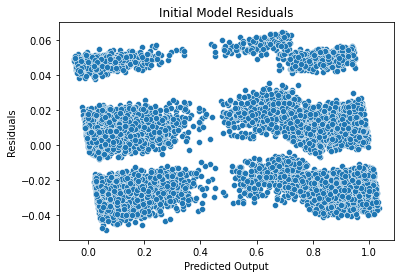

In [19]:
#Initial model residual plot
predictions_init = model_init.predict(X)
sns.scatterplot(x=predictions_init, y=resid.Initial)
plt.title('Initial Model Residuals')
plt.xlabel('Predicted Output')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

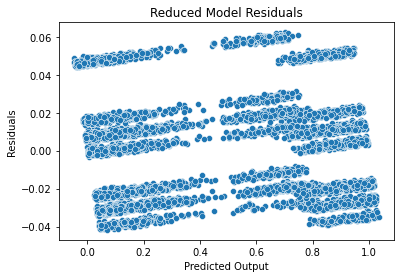

In [20]:
#Reduced model residual plot
predictions_final = model_final.predict(X_final)
sns.scatterplot(x=predictions_final, y=resid.Final)
plt.title('Reduced Model Residuals')
plt.xlabel('Predicted Output')
plt.ylabel('Residuals')

In [21]:
#Residual Error of reduced model
np.sqrt(model_final.ssr / model_final.df_resid)

0.025553433522022162

In [22]:
#Removed Variables
print([x for x in X.columns.to_list() if x not in X_final.columns.to_list()])

['Lat', 'Lng', 'Population', 'Children', 'Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8', 'Marital_Married', 'Marital_Never Married', 'Marital_Separated', 'Marital_Widowed', 'Gender_Male', 'Gender_Nonbinary', 'Services_CT Scan', 'Services_Intravenous', 'Services_MRI', 'Soft_drink', 'Stroke', 'Overweight', 'Asthma', 'Area']


In [23]:
#Reduced model predictions
model_final.predict(X_final).to_list()

[0.12613338464055443,
 0.21927295101181093,
 0.054652869279365905,
 0.012055214546240263,
 0.040984064925655206,
 0.022313022202834237,
 0.145422427083934,
 0.13734053072597663,
 0.10431619032578941,
 0.030103772751716523,
 0.01622533768548181,
 0.11553025987344741,
 0.027033763970275286,
 0.03814249331510844,
 -0.007915816135914834,
 0.0075858914927466395,
 0.0006707262622600435,
 0.08790675731768172,
 0.15825586430760197,
 0.1072556782612434,
 0.06257420252164698,
 0.13975908750672553,
 0.2780356412485319,
 0.10610372299287281,
 0.08310542687458086,
 0.2595596734820635,
 0.20505437624265582,
 0.15104845764162392,
 0.1038113236783201,
 0.3772445162441006,
 0.1034502120438252,
 0.1359490988719114,
 0.11591914315421853,
 0.02695404000308905,
 0.13861216979254865,
 0.1661822135127576,
 0.12433123893118478,
 0.058746174329487075,
 0.09634903118904968,
 0.1478650280742363,
 0.16576039991810718,
 0.2212077977069116,
 0.13703767986341253,
 0.1527762185815643,
 0.0195925613711058,
 0.20788154

In [24]:
#Reduced model coefficients
print(model_final.params)

const                 0.044076
vitD_supp            -0.004455
TotalCharge           1.219207
ReAdmis               0.011825
HighBlood            -0.018208
Arthritis            -0.011372
Diabetes             -0.012685
Hyperlipidemia       -0.015740
BackPain             -0.014182
Anxiety              -0.014624
Allergic_rhinitis    -0.011838
Reflux_esophagitis   -0.010401
Initial_admin        -0.094657
Complication_risk    -0.078014
dtype: float64
